# Projet QI : Étude du modèle de masse de l’aile de l’avion CESSNA C172 Skyhawk

Réalisé par : 
- Abdellah LAASSAIRI
- Paul Léchevin

Project Github repository : [github.com/Abdellah-Laassairi/QI-mass-model-wing-aircraft](https://github.com/Abdellah-Laassairi/QI-mass-model-wing-aircraft)

In [1]:
from IPython.display import display, Latex
import openturns as ot
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
sb.set(rc={'figure.figsize':(11.7,8.27)})

etude = ot.Study()
etude.load()
etude.setStorageManager(ot.XMLH5StorageManager("study/Project_QI.xml"))
etude.save()

## 3.1 Chargement du cas test
> 1. Charger la classe WingWeightModel.

In [2]:
from openturns.usecases.wingweight_function import WingWeightModel

> 2. Copier la distribution jointe des sources d’incertitude dans la variable distribution_entrees.

In [3]:
wing_weight_model = WingWeightModel()
distribution_entrees = wing_weight_model.distributionX

In [4]:
# Les distributions
Sw,Wfw,A,Lambda,q,l,tc,Nz,Wdg,Wp = [distribution_entrees.getMarginal(i).getImplementation() for i in range(distribution_entrees.getDimension())]
copule = distribution_entrees.getCopula().getImplementation()

In [5]:
etude.add("Sw", Sw)
etude.add("Wfw", Wfw)
etude.add("A", A)
etude.add("Lambda", Lambda)
etude.add("q", q)
etude.add("l", l)
etude.add("tc", tc)
etude.add("Nz", Nz)
etude.add("Wdg", Wp)
etude.add("copule", copule)

> 3. Copier la liste des identifiants de ces sources d’incertitude dans la variable nom_sources.

In [6]:
nom_sources = distribution_entrees.getDescription()
latex_nom_sources = ["S_w","W_{fw}","A","\Lambda","q","l","t_c","N_z","W_{dg}","W_p"]

for i in range(len(latex_nom_sources)):

    display(Latex(f"${latex_nom_sources[i]}$ $\sim $ {distribution_entrees.getMarginal(i).getImplementation()}" ))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

> 4. Copier le modèle de masse de l’aile dans la variable model_masse.

In [7]:
model_masse = wing_weight_model.model
# Les modèles
etude.add("model_masse", model_masse)


> 5. Vérifier que ce modèle n’a pas été défini à l’aide d’une fonction symbolique. Créer la fonction
symbolique correspondante (utiliser distribution_entrees pour définir les variables dans
le même ordre) et comparer le gradient et la hessienne des deux implémentations du modèle
au point moyen des entrées. Certaines composantes sont-elles entachées d’une grande erreur
relative?

a. Vérification que ce modèle n’a pas été défini à l’aide d’une fonction symbolique : 

In [8]:
is_symbolic = isinstance(model_masse, ot.SymbolicFunction)
if is_symbolic:
    print("Le modèle est symbolique")
else :
    print("Le modèle n'est pas symbolique")
    print("Il est de type :", model_masse)

Le modèle n'est pas symbolique
Il est de type : class=PythonEvaluation name=OpenTURNSPythonFunction


$$g(S_w, W_{fw}, A,\Lambda, q, l, tc, Nz, Wdg, W_p) = $$

$$0.036*(S_w^{0.758})*(W_{fw}^{0.0035})*(\frac{A}{cos(\Lambda)^2})^{0.6}*(q^{0.006})*(l^{0.04})*(\frac{100*tc}{(cos(\Lambda))})^{-0.3}*((Nz*W_{dg})^{0.49})+S_w*W_p$$

b. Création de la fonction symbolique correspondante :

In [9]:
formula = "0.036*(Sw^0.758)*(Wfw^0.0035)*((A/(cos(Lambda*pi_/180)^2))^0.6)*(q^0.006)*(l^0.04)*(100*tc/(cos(Lambda*pi_/180)))^(-0.3)*((Nz*Wdg)^0.49)+Sw*Wp"
symbolic_function = ot.SymbolicFunction(nom_sources, [formula])

etude.add("symbolic_function", symbolic_function)


c. Comparaison du gradient et la hessienne des deux implémentations du modèle
au point moyen des entrées


Dans le cas où le modèle est une `SymbolicFunction` OpenTURNS est capable de calculer les dérivées exactes en se basant sur la différenciation symbolique. Cependant, pour la `FonctionPython`, l'implémentation par défaut repose sur finite differences. L'erreur relative au gradient exact et à la hessienne dépend du pas (epsilion). Voici les valeurs de pas par défaut pour la fonction CenteredFiniteDifference :

In [10]:
print("CenteredFiniteDifferenceGradient-DefaultEpsilon :", ot.ResourceMap.GetAsScalar("CenteredFiniteDifferenceGradient-DefaultEpsilon") )
print("CenteredFiniteDifferenceHessian-DefaultEpsilon :", ot.ResourceMap.GetAsScalar("CenteredFiniteDifferenceHessian-DefaultEpsilon"))

CenteredFiniteDifferenceGradient-DefaultEpsilon : 1e-05
CenteredFiniteDifferenceHessian-DefaultEpsilon : 0.0001


La modification de la valeur d'epsilon peut avoir un impact important sur la sortie du gradient et sur la hessienne, un pas trop petit ou trop grand conduit à un gradient erroné, en raison du compromis entre la précision de la troncature de la formule de Taylor et les erreurs d'arrondi dans l'évaluation de la fonction.

In [11]:
from openturns import CenteredFiniteDifferenceGradient, CenteredFiniteDifferenceHessian

mean_inputs = distribution_entrees.getMean()

def calculate_gradient_relative_error(gradient_epsilon=1e-7):
    """
    Calculate the relative error between the numerical gradient and the symbolic gradient of a model.

    Parameters
    ----------
    gradient_epsilon : float, optional
        The step used for the finite difference computation. Default is 1e-7.

    Returns
    -------
    ot.Matrix
        A matrix of relative errors between the numerical gradient and the symbolic gradient.
    """

    mean_inputs = distribution_entrees.getMean()

    # Create the centered finite difference gradient model
    finite_difference_gradient_model = CenteredFiniteDifferenceGradient(gradient_epsilon, model_masse.getEvaluation())

    # Compute the numerical and analytical gradients
    model_gradient = finite_difference_gradient_model.gradient(mean_inputs)
    symbolic_gradient = symbolic_function.gradient(mean_inputs)

    # Compute the relative error between the numerical and analytical gradients
    gradient_relative_error = ot.Matrix(model_gradient.getNbRows(), model_gradient.getNbColumns())
    for i in range(model_gradient.getNbRows()):
        for j in range(model_gradient.getNbColumns()):
            if model_gradient[i, j] != 0:
                gradient_relative_error[i, j] = abs((model_gradient[i, j] - symbolic_gradient[i, j]))/abs(model_gradient[i, j])
            else:
                if symbolic_gradient[i, j] == 0:
                    gradient_relative_error[i, j] = 0
                else:
                    gradient_relative_error[i, j] = -1

    return gradient_relative_error


def calculate_hessian_relative_error(hessian_epsilon = 1e-3):

    """
    Calculate the relative error between the numerical Hessian and the symbolic Hessian of a model.

    Parameters
    ----------
    hessian_epsilon : float, optional
        The step used for the finite difference computation. Default is 1e-3.

    Returns
    -------
    ot.Tensor
        A tensor of relative errors between the numerical Hessian and the symbolic Hessian.
    """

    mean_inputs = distribution_entrees.getMean()

    # Create the centered finite difference Hessian model
    finite_difference_hessian_model = CenteredFiniteDifferenceHessian(hessian_epsilon, model_masse.getEvaluation())

    # Compute the numerical and analytical Hessians
    model_hessian = finite_difference_hessian_model.hessian(mean_inputs)
    symbolic_hessian = symbolic_function.hessian(mean_inputs)

    # Compute the relative error between the numerical and analytical Hessians
    hessian_relative_error = ot.Tensor(model_hessian.getNbRows(), model_hessian.getNbColumns(), model_hessian.getNbSheets())
    for i in range(model_hessian.getNbRows()):
        for j in range(model_hessian.getNbColumns()):
            for k in range(model_hessian.getNbSheets()):
                if model_hessian[i, j, k] != 0:
                    hessian_relative_error[i, j, k] = abs((model_hessian[i, j, k] - symbolic_hessian[i, j, k]))/abs(model_hessian[i, j, k])
                else:
                    if symbolic_hessian[i, j, k] == 0:
                        hessian_relative_error[i, j, k] = 0
                    else:
                        hessian_relative_error[i, j, k] = -1
    return hessian_relative_error

In [12]:
print("Number of model evaluations :", symbolic_function.getEvaluationCallsNumber())

Number of model evaluations : 0


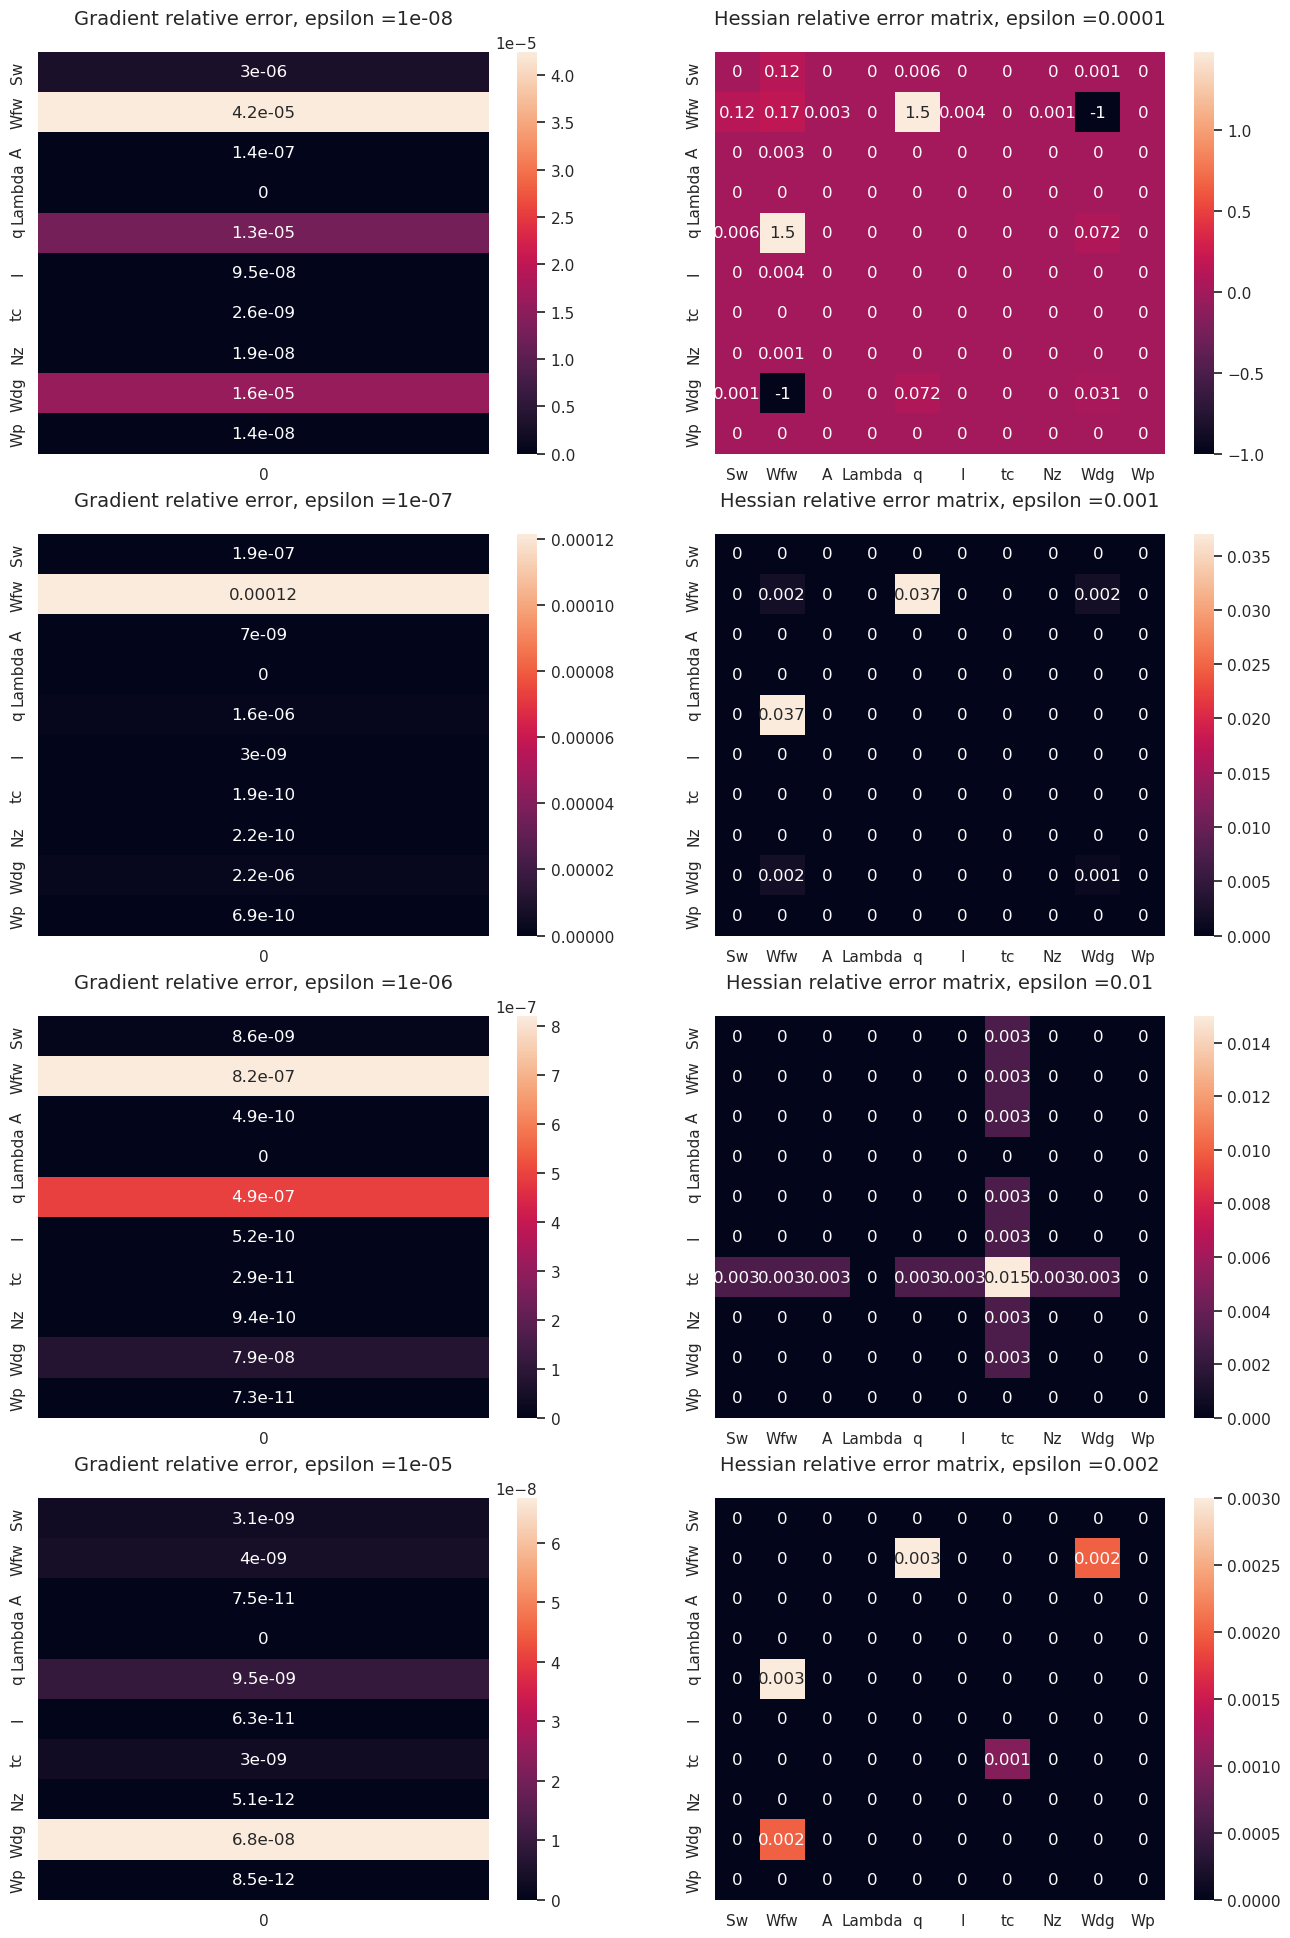

In [13]:
epsilons = [(1e-8, 1e-4), (1e-7, 1e-3), (1e-06, 1e-2),  (1e-05, 0.002) ]
fig, axes = plt.subplots(len(epsilons),2)
fig.set_size_inches(16,6*len(epsilons))

for i in range(len(epsilons)):

    gradient_relative_error=calculate_gradient_relative_error(epsilons[i][0])
    g0 = sb.heatmap(np.array(gradient_relative_error),ax=axes[i][0] ,annot=True)
    g0.yaxis.set_ticklabels(nom_sources)
    g0.set_title(f"Gradient relative error, epsilon ={epsilons[i][0]}", fontsize=14, pad=20)


    hessian_relative_error=calculate_hessian_relative_error(epsilons[i][1])
    g1 = sb.heatmap(np.array(hessian_relative_error)[:,:,0].round(3),ax=axes[i][1], annot=True)
    g1.xaxis.set_ticklabels(nom_sources)
    g1.yaxis.set_ticklabels(nom_sources)
    g1.set_title(f"Hessian relative error matrix, epsilon ={epsilons[i][1]}", fontsize=14, pad=20)

plt.show()

Nous pouvons voir que les meilleurs pas sont $\epsilon = 10^{-5}$ pour le gradient et $\epsilon = 0.002$ pour le Hessien.

- Erreur relative de la hessienne : pour $\epsilon =10^{-4} $ Certaines composantes ont une erreur relative importante car certaines composantes de la hessienne symbolique sont par exemple non nulles alors qu'elles sont nulles dans la hessienne du modèle, ce qui donne une erreur relative en théorie infinie (représentée ici par -1), alors que d'autres composantes ont des erreurs relatives supérieures à 100%. pour $\epsilon =0.002$ L'erreur relative la plus importante est beaucoup plus petite, et la valeur la plus élevée sur $W_{fw}$ et $q$ avec environ 0.3% et entre $Wdg$ et $Wfg$ avec 0.2%.

- Erreur relative du gradient : Pour le gradient, aucune composante n'est sujette à une erreur relative importante.

[source](https://openturns.discourse.group/t/sorm-vs-pythonfunction/88/3?fbclid=IwAR02YCf0cHKOmqQNAAvPn58QCPmqsna0egKGOKC8mr1T6UmjdFHULaADkkI)

> 6. En générant un échantillon de la distribution des sources d’incertitude de taille telle que
l’évaluation de la fonction symbolique prenne au moins 0.1 secondes (tester progressivement
une taille de 100, 1000 etc) en prenant soin à chaque fois d’initialiser la graine du générateur
aléatoire à la valeur 1234, comparer les temps d’évaluation de l’implémentation via une
fonction symbolique et via une fonction Python.

In [14]:
import time
import matplotlib.pyplot as plt
ot.RandomGenerator.SetSeed(1234)

sample_sizes = [100, 1000, 10000, 100000, 1000000,2500000 ]
symbolic_time = 0
symbolic_time_list = []
model_time_list = []

# Mesurez le temps d'évaluation de model_masse
for sample_size in sample_sizes:
    sample = distribution_entrees.getSample(sample_size)    
    duration = 0
    start_time = time.time()
    python_output = model_masse(sample)
    duration = time.time() - start_time
    model_time_list.append(duration)

# Mesurez le temps d'évaluation de la fonction symbolique
for sample_size in sample_sizes:
    sample = distribution_entrees.getSample(sample_size)
    duration = 0
    start_time = time.time()
    symbolic_output = symbolic_function(sample)
    duration  = time.time() - start_time
    symbolic_time_list.append(duration)

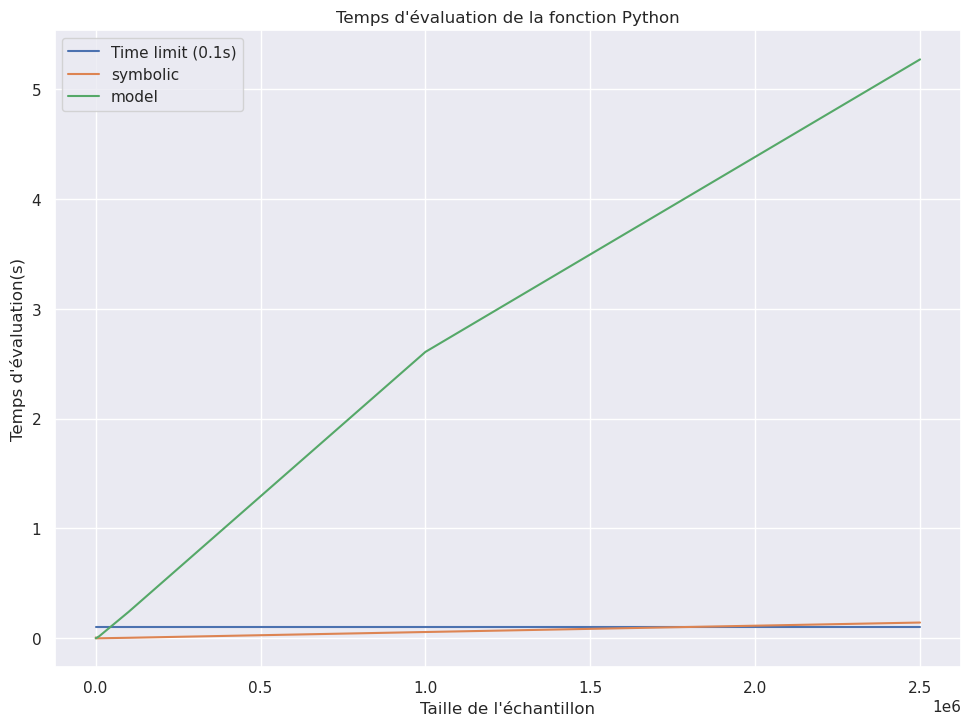

In [15]:
plt.title("Temps d'évaluation de la fonction Python")
plt.xlabel("Taille de l'échantillon")
plt.ylabel("Temps d'évaluation(s)")
plt.plot(sample_sizes, [0.1]*len(sample_sizes), label="Time limit (0.1s)")
plt.plot(sample_sizes, symbolic_time_list, label="symbolic")
plt.plot(sample_sizes, model_time_list, label="model") # Add subtitle to the plot
plt.legend()
plt.show()

In [16]:
final_sample = distribution_entrees.getSample(2000000)


In [17]:
%%timeit -r 10
symbolic_output = symbolic_function(final_sample)

171 ms ± 18.4 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [18]:
%%timeit -r 10
python_output = model_masse(sample)

3.96 s ± 315 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


- The average execution time for the symbolic function for a sample of size 2 000 000 is : 142 ms
- The average execution time for the python   function for a sample of size 2 000 000 is : 3.93 s 

We can conlude that the symbolic function is more efficient than the python function in terms of execution speed

In [19]:
question_six_model_evaluations = symbolic_function.getEvaluationCallsNumber()
print("Number of model evaluations :", question_six_model_evaluations)

Number of model evaluations : 225611100


On utilisera désormais l’implémentation via une fonction symbolique.
## 3.2 Variables d’entrée et de sortie
> 7. Créer le vecteur aléatoire X dans la variable X des sources d’incertitude.

In [20]:
X = ot.RandomVector(distribution_entrees)

> 8. Créer le vecteur aléatoire M dans la variable M correspondant à la masse de l’aile.

In [21]:
M = ot.CompositeRandomVector(symbolic_function, X)

> 9. Peut-on obtenir la distribution de M à l’aide de l’algèbre des distributions?

Non il n'est pas possible d'obtenir la distribution de `M` à l'aide de l'algèbre des distributions parce que sa formule fait intervenir deux fois la distribution de la surface de l'aile. Utiliser l'algèbre des distributions aurait donc pour effet d'avoir deux copies indépendantes et de même distribution que celle de la la surface de l'aile.

De plus le fait d'avoir un nombre élevé de distributions (ie 10 distributions) dans la formule de la masse de l'aile rendrait les calculs très fastidieux.

In [22]:
# algebre_distribution_masse_aile = 0.036*Sw**0.758*Wfw**0.0035*(A/np.cos(np.pi*Lambda/180)**2)**0.6*q**0.006*l*0.04*(100*tc/np.cos(np.pi*Lambda/180))**(-0.3)*(Nz*Wdg)*0.49 + Sw*Wp
# This takes 17 Minutes to complete
# etude.add("algebre_distribution_masse_aile", algebre_distribution_masse_aile)

> 10. Calculer la distribution de la masse de la peinture à l’aide de l’algèbre des distributions et tracer sa densité.

$M_p =W_p * S_w$

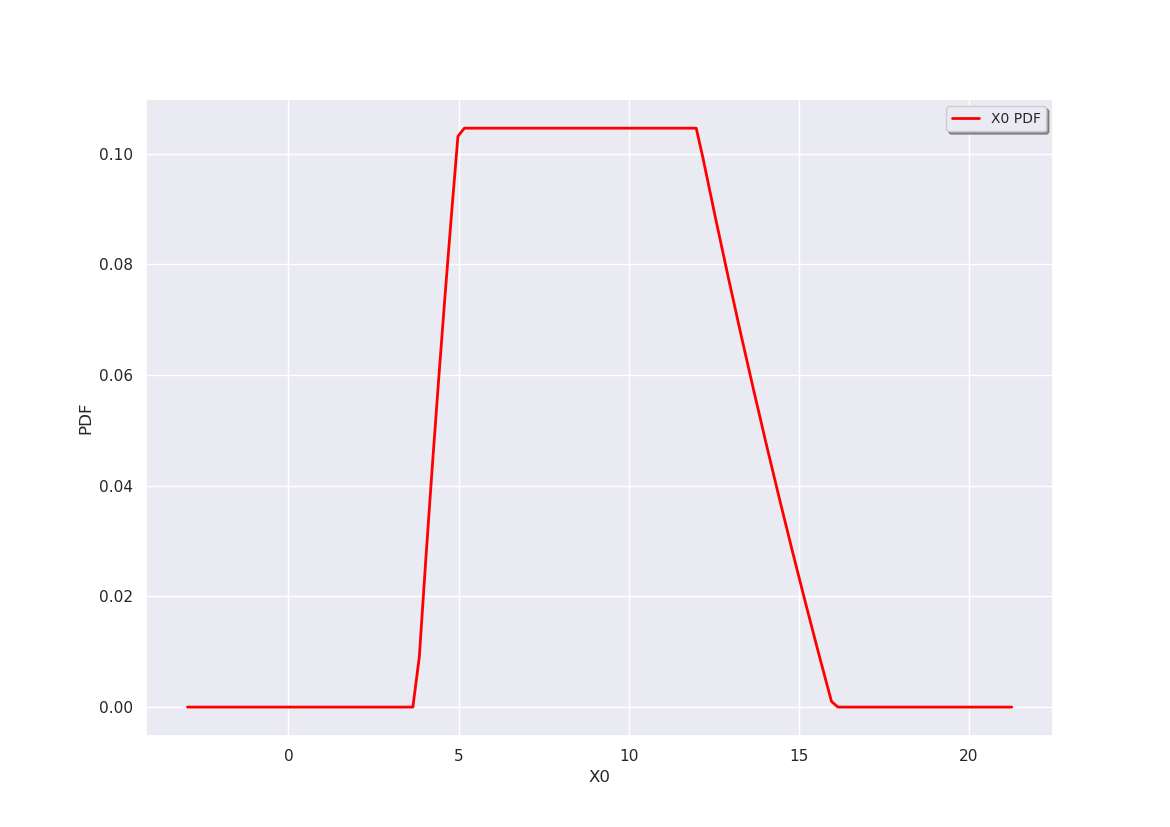

In [23]:
Mp=Wp*Sw
Mp.drawPDF()

In [24]:
etude.add("Mp", Mp)
etude.save()

## 3.3 Analyse en tendance centrale
On effectue d’abord une analyse de la moyenne et de la variance de la masse à l’aide d’une
approximation de Taylor du modèle au point moyen des sources d’incertitudes à l’aide de la classe
TaylorExpansionMoments.

> 11. Que valent la moyenne à l’ordre 0 et la moyenne à l’ordre 2 de M? Le calcul précis de la hessienne est-il critique?

La précision du calcul de la hessienne est importante pour estimer la variance de la sortie en utilisant l'approximation de Taylor. Si la hessienne est mal calculée, cela peut entraîner des erreurs dans l'estimation de la variance. Ceci est également indiqué par Openturns, si nous utilisons l'implémentation par défaut de la hessienne en utilisant le modèle_masse pour définir M, nous obtiendrons l'avertissement suivant: 
$\color{blue}{\text{WRN - You are using a default implementation for the hessian. Be careful, your computation can be severely wrong!}}$ Mais comme nous utilisons la fonction symbolique pour définir M, nous disposons de l'expression hessienne exacte, il n'y a donc pas d'erreur dans les calculs.


In [33]:
# Effectuer une approximation de Taylor du modèle au point moyen des sources d'incertitudes
taylor_expansion_moments = ot.TaylorExpansionMoments(M)

# Calculer la moyenne d'ordre 0 et d'ordre 2 de M
mean_order_0 = taylor_expansion_moments.getMeanFirstOrder()
mean_order_2 = taylor_expansion_moments.getMeanSecondOrder()

print("Moyenne d'ordre 0 de M :", mean_order_0[0])
print("Moyenne d'ordre 2 de M :", mean_order_2[0])

Moyenne d'ordre 0 de M : 267.6246925704357
Moyenne d'ordre 2 de M : 268.02224976566663


> 12. Que vaut la variance à l’ordre 1 de M?

In [34]:
# Calculer la variance d'ordre 1 de M
covariance_matrix_order_1 = taylor_expansion_moments.getCovariance()

print("Variance d'ordre 1 de M :", round(covariance_matrix_order_1[0, 0],2))

Variance d'ordre 1 de M : 2195.56


> 13. Calculer les facteurs d’importance des composantes de X dans la variance de M.

In [36]:
# Calculer les facteurs d'importance des composantes de X dans la variance de M
importance_factors = taylor_expansion_moments.getImportanceFactors()

print("Facteurs d'importance des composantes de X dans la variance de M:")
for i, factor in enumerate(importance_factors):
    print(f"{nom_sources[i]} : {100*factor:.5f} %")

Facteurs d'importance des composantes de X dans la variance de M:
Sw : 13.03154 %
Wfw : 0.00029 %
A : 22.81527 %
Lambda : 0.00000 %
q : 0.00825 %
l : 0.18027 %
tc : 13.50016 %
Nz : 41.27942 %
Wdg : 8.83317 %
Wp : 0.35162 %


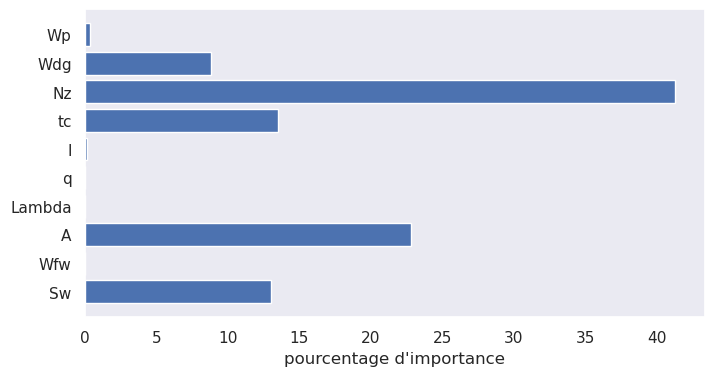

In [39]:
plt.figure(figsize=(8,4))
plt.barh(nom_sources,[100*factor for factor in importance_factors])
plt.xlabel("pourcentage d'importance")
plt.grid()
plt.show()

> 14. On considère que la composante Xi est importante dès lors que son facteur d’importance est supérieur à 0.5%. Quelles sont les composantes importantes et les composantes négligables selon ce critère?

In [ ]:
# Seuil d'importance
threshold = 0.005

important_components = []
negligible_components = []

for i, factor in enumerate(importance_factors):
    if factor > threshold:
        important_components.append(i)
    else:
        negligible_components.append(i)

print("Composantes importantes :", nom_sources[important_components])
print("Composantes négligeables :", nom_sources[negligible_components])

Composantes importantes : [Sw,A,tc,Nz,Wdg]
Composantes négligeables : [Wfw,Lambda,q,l,Wp]


On souhaite confronter cette analyse en calculant les indices de Sobol totaux de chacune des
composantes de X, calculés à partir de la décomposition de Sobol de la fonction de masse.

> 15. Construire la décomposition de Sobol du modèle à l’aide de l’algorithme FunctionalChaosAlgorithm en utilisant un plan d’expérience de type Monte Carlo (classe MonteCarloExperiment) de taille 1000 associé à la distribution des incertitudes.

In [42]:
inputDim = distribution_entrees.getDimension()
samplingSize=1000

# Building the multivariate orthonormal basis:
polyColl = [0.0]*inputDim
for i in range(inputDim):
    polyColl[i] = ot.StandardDistributionPolynomialFactory(distribution_entrees.getMarginal(i))
enumerateFunction = ot.LinearEnumerateFunction(inputDim)
productBasis = ot.OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)

# We keep all the polynomials of degree <= 3

degree = 3
indexMax = enumerateFunction.getStrataCumulatedCardinal(degree)
adaptiveStrategy = ot.FixedStrategy(productBasis, indexMax)

# Definining the evaluation strategy of the coefficients:

experiment = ot.MonteCarloExperiment(distribution_entrees, samplingSize)
X = experiment.generate()
Y = symbolic_function(X)
projectionStrategy = ot.LeastSquaresStrategy()

chaos_algorithm = ot.FunctionalChaosAlgorithm(X, Y, distribution_entrees, adaptiveStrategy, projectionStrategy)
chaos_algorithm.run()
chaos_result = chaos_algorithm.getResult()

In [43]:
nom_sources_list = ["Sw","Wfw","A","Lambda","q","l","tc","Nz","Wdg","Wp"]

In [44]:
from openturns.viewer import View
import numpy as np
sobol_indices = ot.SobolIndicesAlgorithm(chaos_result.getDistribution(), 1000, chaos_result.getMetaModel())
total_sobol_indices = sobol_indices.getTotalOrderIndices()
#sobol_indices.DrawImportanceFactors(total_sobol_indices, nom_sources, 'Total order indices')
fig = px.pie(values=np.array(total_sobol_indices), names=nom_sources_list, title='Total order indices')
fig.show()

> 16. En générant un échantillon indépendant et de même taille, valider graphiquement la qualité de la décomposition. On calculera également le coefficient de détermination. Pour cela, on utilisera la classe MetaModelValidation.

In [45]:
validation_sample = distribution_entrees.getSample(samplingSize)
output_sample = symbolic_function(validation_sample)
validation = ot.MetaModelValidation(validation_sample, output_sample, chaos_result.getMetaModel())
R2 = validation.computePredictivityFactor()[0]
print(f"Coefficient of determination R^2: {R2}")

Coefficient of determination R^2: 0.9999919052115066


/home/odeck/.local/lib/python3.10/site-packages/openturns/viewer.py:655: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



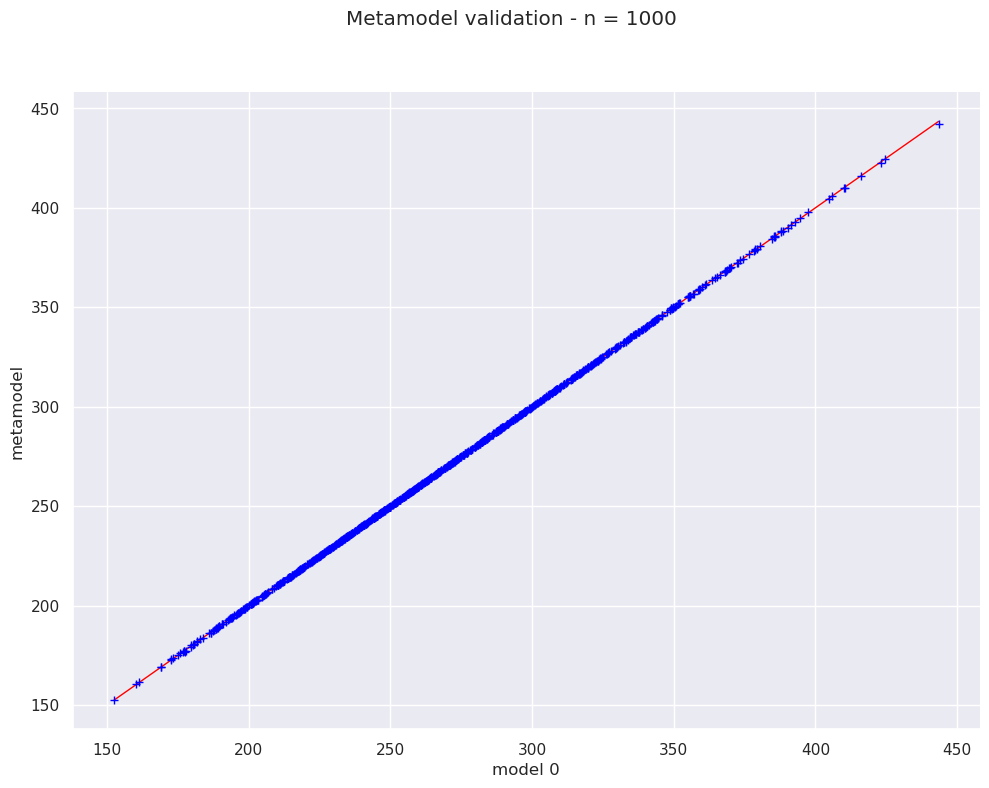

In [46]:
graph = validation.drawValidation()
View(graph).show()

> 17. En déduire une estimation des indices de Sobol totaux de chacune des composantes de X. En appliquant le même critère que pour les facteurs d’importance issus du développement de Taylor, quels sont les composantes influentes et celles qui ne le sont pas? Comparer avec le classement obtenu précédemment.

Composantes importantes: [Sw,A,tc,Nz,Wdg]
Composantes négligeables: [Wfw,Lambda,q,l,Wp]


/tmp/ipykernel_123270/3812012486.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,value,variables,type
0,0.130733,Sw,sobol
1,0.000003,Wfw,sobol
2,0.227264,A,sobol
3,0.000523,Lambda,sobol
4,0.000090,q,sobol
5,0.001948,l,sobol
6,0.150144,tc,sobol
7,0.456404,Nz,sobol
8,0.082995,Wdg,sobol
9,0.003289,Wp,sobol


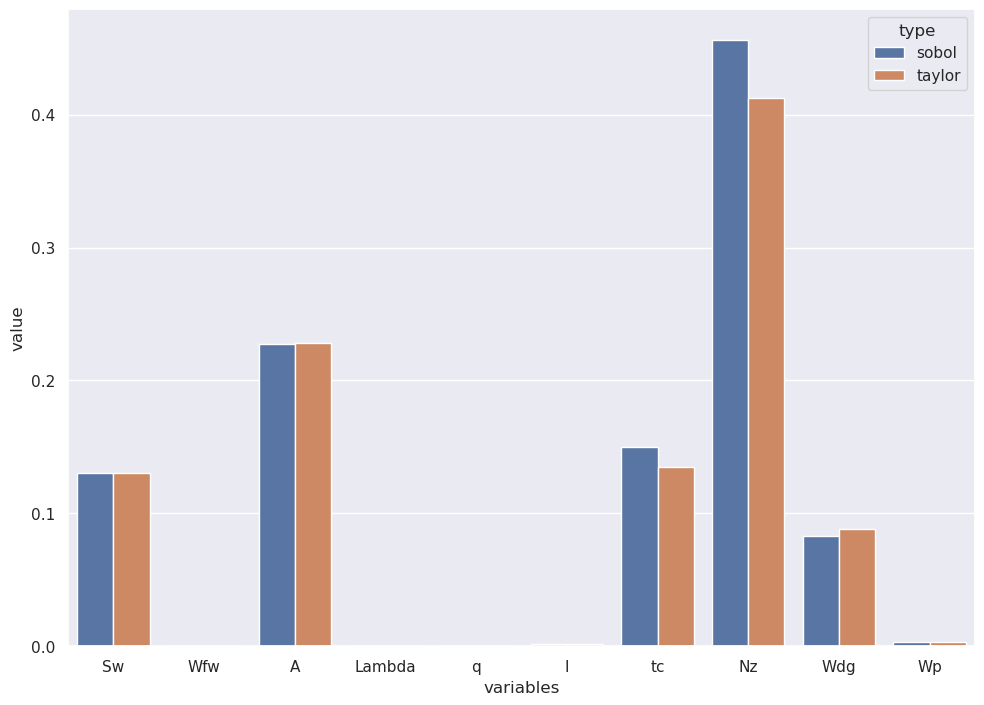

In [47]:
threshold = 0.005  # 0.5% threshold
influential_components = []
non_influential_components = []

# Seuil d'importance
threshold = 0.005

important_components = []
negligible_components = []

for i, index in enumerate(total_sobol_indices):
    if index > threshold:
        influential_components.append(i)
    else:
        non_influential_components.append(i)

print("Composantes importantes:", nom_sources[influential_components])
print("Composantes négligeables:", nom_sources[non_influential_components])

df1 = pd.DataFrame({})
df1["value"]=np.array(total_sobol_indices)
df1["variables"]=nom_sources_list
df1["type"]=["sobol" for _ in range(len(nom_sources_list))]

df2=pd.DataFrame({})
df2["value"]=(np.array(importance_factors))
df2["variables"]=(nom_sources_list)
df2["type"]=(["taylor" for _ in range(len(nom_sources_list))])

df=df1.append(df2)
# fig = px.bar(df,x="variables", y="value",color="type", title='Importance',barmode='group')
# fig.show()
sb.barplot(df,x="variables", y="value", hue="type")
df

On souhaite tester le fait que certaines composantes de X ne sont pas influentes en les fixant à leur valeur moyenne dans le modèle et en comparant le modèle réduit ainsi obtenu au modèle initial.

> 18. Construire le modèle réduit reliant les composantes influentes de X à M. On utilisera la classe ParametricFunction.

In [48]:
reduced_input_distribution = ot.ComposedDistribution([distribution_entrees.getMarginal(i) for i in influential_components])

In [49]:
def constant_non_influential(input_distribution, non_influential_components):
    mean_values=[]
    for i in non_influential_components:
        mean_values.append(input_distribution.getMarginal(i).getMean()[0])
    return mean_values

In [50]:
mean_values = constant_non_influential(distribution_entrees, non_influential_components)
mean_values

[260.0, 0.0, 30.5, 0.75, 0.052500000000000005]

In [51]:
reduced_model = ot.ParametricFunction(symbolic_function, non_influential_components, mean_values)

> 19. Extraire l’échantillon marginal correspondant à ces composantes de l’échantillon de test précédent.

In [52]:
test_sample = distribution_entrees.getSample(samplingSize)
influential_test_sample = test_sample.getMarginal(influential_components)

In [53]:
influential_test_sample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1000 dimension=5 description=[Sw,A,tc,Nz,Wdg] data=[[155.925,8.75806,0.114809,4.55502,2453.43],[199.223,7.02027,0.125685,3.55048,1866.01],[198.663,9.41908,0.144081,4.62992,1834.96],...,[168.676,6.51628,0.137903,3.54066,2460.2],[194.702,6.69196,0.155835,5.97665,1749.83],[179.854,9.91262,0.150461,4.51243,1874.48]]

> 20. En utilisant le modèle réduit comme méta-modèle du modèle initial, valider graphiquement le fait qu’on puisse fixer les entrées incertaines non influentes à leur valeur moyenne. Que vaut le coefficient de détermination?

In [54]:
from openturns import MetaModelValidation

full_model_output = symbolic_function(test_sample)
reduced_model_output = reduced_model(influential_test_sample)

validation = MetaModelValidation(influential_test_sample, full_model_output, reduced_model)
r_squared = validation.computePredictivityFactor()
print("Coefficient of determination (R-squared):", round(r_squared[0],3))

Coefficient of determination (R-squared): 0.993


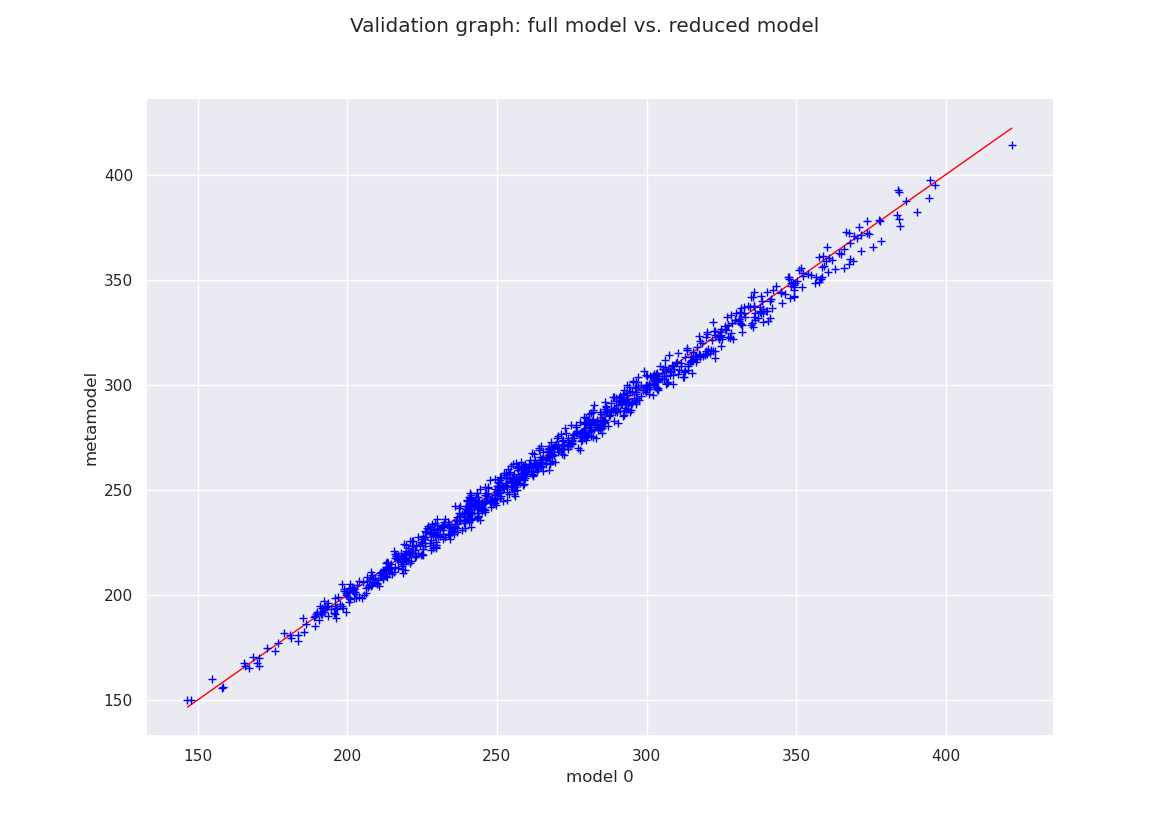

In [55]:
validation_graph = validation.drawValidation()
validation_graph.setTitle("Validation graph: full model vs. reduced model")
validation_graph

Le graphique de validation compare la sortie complète du modèle (axe x) avec la sortie réduite du modèle (axe y). Plus les points sont proches de la diagonale, plus le modèle réduit se rapproche du modèle complet, ce qui est le cas dans le graphique ci-dessus. La valeur calculée du coefficient de détermination fournit une mesure de la façon dont le modèle réduit explique la variabilité du modèle complet. Une valeur proche de 1 indique un bon ajustement.

## 3.4 Analyse d’un événement rare

On souhaite garantir avec grande probabilité que la masse de l’aile reste en dessous d’une limite
$M_{max} = 460$ lb. Pour cela, on souhaite calculer la probabilité de l’événement E = {M ≥ Mmax}.

> 21. Construire l’événement E.

In [56]:
from openturns import ThresholdEvent

M_max = 460
E = ThresholdEvent(M, ot.GreaterOrEqual(), M_max)

> 22. En utilisant la méthode FORM, calculer une approximation de la probabilité de E. Combien d’appels au modèle ont été nécessaires? On utilisera l’algorithme d’optimisation Cobyla initialisé au point moyen.

> 23. Calculer l’approximation donnée par SORM (formule de Breitung). L’effet des courbures est-il important?

In [57]:
from openturns import Cobyla, FORM
# Define the optimization algorithm
optimization_algorithm = Cobyla()
optimization_algorithm.setStartingPoint(distribution_entrees.getMean())

# Perform FORM analysis
form = FORM(optimization_algorithm, E, distribution_entrees.getMean())
form.run()
result_form = form.getResult()

# Get the probability estimate and the number of function evaluations
probability_estimate = result_form.getEventProbability()
model_evaluations = symbolic_function.getEvaluationCallsNumber()-question_six_model_evaluations

print("Probability estimate using FORM :", round(probability_estimate,6))
print("Number of model evaluations :", model_evaluations)

Probability estimate using FORM : 0.00051
Number of model evaluations : 6535


In [58]:
from openturns import SORM

# Perform SORM analysis
sorm = SORM(optimization_algorithm, E, distribution_entrees.getMean())
sorm.run()
sorm_result = sorm.getResult()

# Get the probability estimate using Breitung's formula
probability_estimate_sorm = sorm_result.getEventProbabilityBreitung()
curvatures = sorm_result.getSortedCurvatures()
model_evaluations = symbolic_function.getEvaluationCallsNumber()-question_six_model_evaluations

print("Probability estimate using SORM (Breitung's formula) :", round(probability_estimate_sorm,6))
print("Model Evaluations :", model_evaluations)
print("Curvatures :", curvatures)

Probability estimate using SORM (Breitung's formula) : 8.4e-05
Model Evaluations : 7066
Curvatures : [-0.225411,1.22682e-16,0.000793124,0.0132969,0.0488459,0.0806327,0.522802,0.607604,0.693961,0.744964]#10


La différence entre les estimations de probabilité utilisant FORM et SORM (formule de Breitung) est significative :

- Estimation de probabilité FORM : 5.0964172524139e-04
- Estimation de probabilité SORM : 8.4145113541429e-05

L'approximation SORM est d'un ordre de grandeur inférieure. Cela indique que l'effet des courbures est important dans ce cas. L'effet de courbure capture l'influence de la non-linéarité de la fonction d'état limite sur l'estimation de la probabilité. La méthode FORM étant une approximation de premier ordre, elle peut ne pas bien rendre compte de cet effet. C'est pourquoi la méthode SORM peut fournir une estimation plus précise dans les cas où l'effet de courbure est significatif.

> 24. Calculer les facteurs d’importance issus de l’approximation FORM. En appliquant le même critère de sélection que précédemment, quelles sont les variables influentes?

Important variables : [Sw,A,l,tc,Nz,Wdg,Wp]


/tmp/ipykernel_123270/3335718612.py:35: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,value,variables,type
0,0.130733,Sw,sobol
1,0.000003,Wfw,sobol
2,0.227264,A,sobol
3,0.000523,Lambda,sobol
4,0.000090,q,sobol
5,0.001948,l,sobol
6,0.150144,tc,sobol
7,0.456404,Nz,sobol
8,0.082995,Wdg,sobol
9,0.003289,Wp,sobol


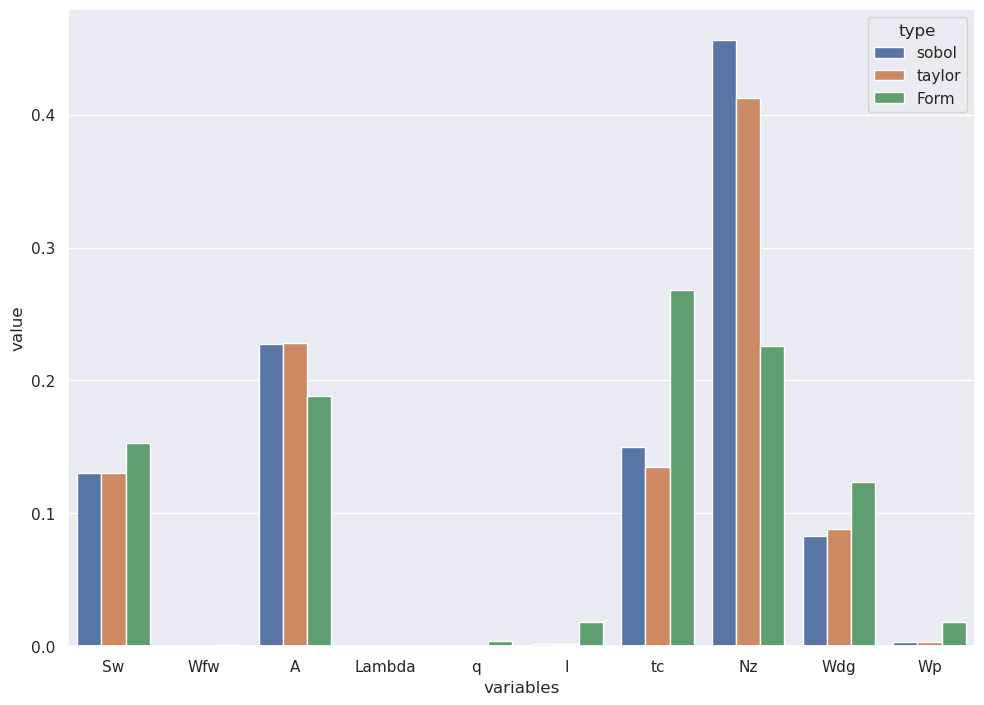

In [59]:
# Importance Threshold
threshold = 0.005
epsilon = 1e-7
# Compute the gradient at the design point
design_point_standard_space = result_form.getStandardSpaceDesignPoint()

# We should first transform the design point back to the physical space before evaluating the model
design_point_physical_space = distribution_entrees.getInverseIsoProbabilisticTransformation()(design_point_standard_space)

finite_difference_gradient_model = CenteredFiniteDifferenceGradient(epsilon, symbolic_function.getEvaluation())
gradient = finite_difference_gradient_model.gradient(design_point_physical_space)

# Calculate the importance factors
marginal_standard_deviations = distribution_entrees.getStandardDeviation()
importance_factors_form = []
for i in range(distribution_entrees.getDimension()):
    factor = abs(gradient[i, 0]) * marginal_standard_deviations[i]
    importance_factors_form.append(factor)
importance_factors_form = ot.Point(importance_factors_form)
importance_factors_form /= sum(importance_factors_form)

# Apply the selection criterion (importance factor > 0.5%)
important_variables = []
for i, factor in enumerate(importance_factors_form):
    if factor >= threshold:
        important_variables.append(i)

print("Important variables :", nom_sources[important_variables])

df3 = pd.DataFrame({})
df3["value"]=(np.array(importance_factors_form))
df3["variables"]=(nom_sources_list)
df3["type"]=(["Form" for _ in range(len(nom_sources_list))])

df4 = df.append(df3)
# fig = px.bar(df4,x="variables", y="value",color="type", title='Importance',barmode='group')
# fig.show()
sb.barplot(df4,x="variables", y="value", hue="type")
df4


> 25. En utilisant un tirage préférentiel couplé à une variable de contrôle construite à partir du résultat de la méthode FORM, estimer la probabilité de E avec un coefficient de variation de 0.1, une taille de bloc de 10 et un nombre maximum d’itérations de 105. Combien d’appels au modèle ont été nécessaires pour cette étape ? En tout, en comptabilisant ceux du calcul FORM ? Comparer avec le nombre d’appels qu’aurait nécessité la méthode de Monte Carlo standard.

$\color{blue}{\text{Je suis pas sûr de comprendre ce qu'est le coefficient de variation, donc pas sûr de mon résultat.}}$

In [60]:
# Définir la taille de bloc et le nombre maximum d'itérations
block_size = 10
max_iterations = 105
max_coeff_variation = 0.1

cis = ot.PostAnalyticalImportanceSampling(result_form)

#algo = ot.ProbabilitySimulationAlgorithm(E, experiment)
cis.setBlockSize(block_size)
cis.setMaximumCoefficientOfVariation(max_coeff_variation)
cis.setMaximumOuterSampling(max_iterations) # pas sûr
cis.run()
cis.getResult()

probabilityEstimate=4.642301e-05 varianceEstimate=4.084779e-11 standard deviation=6.39e-06 coefficient of variation=1.38e-01 confidenceLength(0.95)=2.51e-05 outerSampling=105 blockSize=10

Pour cette étape, 105 appels au modèle ont été nécessaire, et en tout, en comptabilisant ceux du calcul FORM, 6 105 appels au modèle ont été nécessaires.

La méthode de Monte-Carlo standard permet d'estimer la probabilité p de l'évènement E à l'aide de l'intervalle de confiance à 95% suivant :
$$[p- 1.96 \frac{\sigma}{\sqrt{n}} ; p + 1.96 \frac{\sigma}{\sqrt{n}}] \text{ où } \sigma = \sqrt{p(1-p}$$

Pour obtenir un coefficient de variation de 0.1, il aurait donc fallu un nombre n d'appels au modèle donné par l'équation :
$$1.96 \frac{\sqrt{p(1-p}}{n} = \frac{p}{10}$$
soit :
$$10 \times 1.96^{2} p(1-p) = p^{2} n$$
ou encore :
$$n = \frac{10 \times 1.96^{2} (1-p)}{p}$$
et finalement :
$$n \sim \frac{40}{p} \sim 500 000$$

> 26. Bonus : reprendre ces calculs en utilisant le modèle réduit dans lequel les variables jugées peu influentes ont été fixées à leur valeur moyenne. Est-ce que la probabilité de E a beaucoup changé (erreur relative)?

In [61]:
X_reduced = ot.RandomVector(reduced_input_distribution)
M_reduced = ot.CompositeRandomVector(reduced_model, X_reduced)

In [62]:
M_max = 460
E_reduced = ThresholdEvent(M_reduced, ot.GreaterOrEqual(), M_max)

In [63]:
# Run the FORM analysis with the reduced model
former_model_evaluations = symbolic_function.getEvaluationCallsNumber()

algo_form_reduced = ot.FORM(ot.Cobyla(), E_reduced, reduced_input_distribution.getMean())
algo_form_reduced.run()
result_form_reduced = algo_form_reduced.getResult()

current_model_evaluations = symbolic_function.getEvaluationCallsNumber()
reduced_model_evaluations = current_model_evaluations-former_model_evaluations

print("Number of reduced model evaluations :", reduced_model_evaluations)

Number of reduced model evaluations : 159


In [64]:
# Définir la taille de bloc et le nombre maximum d'itérations
block_size = 10
max_iterations = 105
max_coeff_variation = 0.1

cis_reduced = ot.PostAnalyticalImportanceSampling(result_form_reduced)

#algo = ot.ProbabilitySimulationAlgorithm(E, experiment)
cis_reduced.setBlockSize(block_size)
cis_reduced.setMaximumCoefficientOfVariation(max_coeff_variation)
cis_reduced.setMaximumOuterSampling(max_iterations) # pas sûr
cis_reduced.run()
cis_reduced.getResult()

probabilityEstimate=3.625302e-05 varianceEstimate=2.551450e-11 standard deviation=5.05e-06 coefficient of variation=1.39e-01 confidenceLength(0.95)=1.98e-05 outerSampling=105 blockSize=10

Utiliser le modèle réduit a permis de réduire le nombre d'appels au modèle, en n'en réalisant que 264, tout en conservant une bonne estimation de la probabilité recherchée (30% d'erreur relative).